# Convolutional Neural Network Model - Hiperparameters Tuning

Input: testing different number of months in input using single PCA

Output: optimal max-shape portfolio with tight restrictions for the next period

## Data Pre-processing

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv1D, Dropout
from keras.regularizers import L2
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
import keras_tuner

from helper_functions import train_and_evaluate_model, calculate_returns_for_model, daily_to_annual_returns

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [3]:
data_provider = DataProvider()
y = data_provider.get_formatted_targets()

c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\lukas\Documents\Master mAI-X\TFM\venv\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


## Cross validation to calculate optimal number of months

In [4]:
df_countries, _ = data_provider.get_etf_data()
days_to_recalculate = data_provider.get_days_to_recalculate()

val_split = int(0.7 * y.shape[0])
test_split = int(0.8 * y.shape[0])
dates_for_validation = days_to_recalculate[val_split:test_split]

df_prices_val = df_countries[dates_for_validation[0]:]
df_returns_val = np.log(df_prices_val).diff().fillna(0)

In [5]:
max_sharpe = 0
best_month_no = 0

for no_months in range(3, 10):
    print(f'CNN Model for {no_months} months')
    x = data_provider.get_formatted_features(no_months=no_months)
    x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    skf.get_n_splits(x_train, y_train)

    sum_sharpe = 0
    for _, (train_index, val_index) in enumerate(skf.split(x_train, np.zeros(y_train.shape[0]))):
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]
        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        model = Sequential((
            Input(shape=x_train.shape[1:]),
            Conv1D(32, 3),
            Flatten(),
            Dropout(0.3),
            Dense(16, activation='relu', kernel_regularizer=L2(0.3)),
            Dense(y_train.shape[1], activation='softmax')
        ))
        model.compile(optimizer=Adam(learning_rate=1e-3),
                      loss='mean_squared_error')
        _ = model.fit(x_train_fold, y_train_fold,
                      validation_data=(x_val_fold, y_val_fold),
                      epochs=200, verbose=False)

        total_ret_val, _ = calculate_returns_for_model(
            model, x_val, dates_for_validation, df_returns_val)

        annual_returns = daily_to_annual_returns(total_ret_val)
        annual_volatility = total_ret_val.std()*np.sqrt(252)
        annual_sharpe_val = annual_returns/annual_volatility
        sum_sharpe += annual_sharpe_val
        print('Sharpe fold', annual_sharpe_val)

    mean_sharpe_val = sum_sharpe/5
    print('Mean Sharpe', mean_sharpe_val)
    if mean_sharpe_val > max_sharpe:
        max_sharpe = mean_sharpe_val
        best_month_no = no_months

print('Best number of months', best_month_no, 'with mean Sharpe ratio', max_sharpe)

CNN Model for 3 months
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Sharpe fold 0.3932100929093433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sharpe fold 0.3803386079458115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3865342744863432
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.39041122027677444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sharpe fold 0.3903244563435046
Mean Sharpe 0.3881637303923554
CNN Model for 4 months
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Sharpe fold 0.4008204000733961
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sharpe fold 0.4058628898361215
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.3869472488014912
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Sharpe fold 0.3957547300815918
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.39123820555981176
Mean Sharpe 0.39612469487048246
CNN Model for 5 months
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Sharpe fold 0.3993271365253429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Sharpe fold 0.40453507536583017
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

In [40]:
best_month_no = 7

x = data_provider.get_formatted_features(no_months=best_month_no)
x_train, y_train, x_val, y_val, x_test, y_test = data_provider.train_train_split(x, y)

## Hiperparameters Tuning

In [45]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=x_train.shape[1:]))
    model.add(Conv1D(hp.Choice('conv_units', [32, 64, 128, 256]), 3,
                     input_shape=x_train.shape[1:]))
    model.add(Flatten())
    model.add(Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])))

    model.add(Dense(hp.Choice('dense_units', [32, 64]), 
                    activation='relu',
                    kernel_regularizer=L2(hp.Choice('regularizer', [0.1, 0.2, 0.3, 0.4]))))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='mse')
    return model

In [46]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=300,
    directory='tuning',
    project_name='model_cnn')

In [47]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
conv_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128, 256], 'ordered': True}
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
dense_units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
regularizer (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.2, 0.3, 0.4], 'ordered': True}


In [48]:
tuner.search(x_train, y_train, epochs=150, validation_data=(x_val, y_val))

Trial 92 Complete [00h 00m 08s]
val_loss: 0.0005663185729645193

Best val_loss So Far: 0.0005663185729645193
Total elapsed time: 00h 12m 11s


In [49]:
tuner.results_summary()

Results summary
Results in tuning\model_cnn
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 091 summary
Hyperparameters:
conv_units: 32
dropout: 0.4
dense_units: 32
regularizer: 0.1
Score: 0.0005663185729645193

Trial 023 summary
Hyperparameters:
conv_units: 64
dropout: 0.4
dense_units: 32
regularizer: 0.2
Score: 0.0006136741139926016

Trial 084 summary
Hyperparameters:
conv_units: 32
dropout: 0.3
dense_units: 32
regularizer: 0.2
Score: 0.0006171469576656818

Trial 068 summary
Hyperparameters:
conv_units: 32
dropout: 0.3
dense_units: 64
regularizer: 0.1
Score: 0.0006270544836297631

Trial 043 summary
Hyperparameters:
conv_units: 64
dropout: 0.2
dense_units: 32
regularizer: 0.2
Score: 0.0006282715476118028

Trial 007 summary
Hyperparameters:
conv_units: 32
dropout: 0.2
dense_units: 64
regularizer: 0.1
Score: 0.000629680638667196

Trial 020 summary
Hyperparameters:
conv_units: 64
dropout: 0.3
dense_units: 32
regularizer: 0.2
Score: 0.0006524711498059332

Trial 0

## Best Model training

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 5, 32)          │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         5,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │           891 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,667 (33.86 KB)

 Trainable params: 8,667 (33.86 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.1271 - val_loss: 4.6694 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5347 - val_loss: 4.1199 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9970 - val_loss: 3.6230 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5123 - val_loss: 3.1765 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0795 - val_loss: 2.7794 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.6948 - val_loss: 2.4285 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3535 - val_loss: 2.1183 - learning_rate: 0.0010
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0516 - val_loss: 1.8440 - learning_rate: 0.0010
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7853 - val_loss: 1.6020 - learning_rate: 0.0010
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━

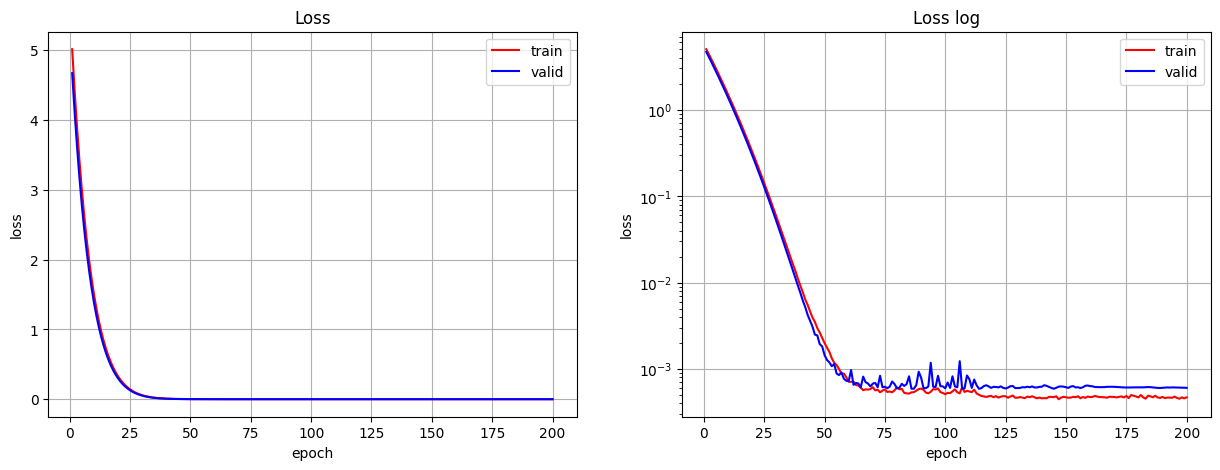

In [58]:
# best_model = tuner.get_best_models()[0]

best_model = Sequential((
    Input(shape=x_train.shape[1:]),
    Conv1D(32, 3),
    Flatten(),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=L2(0.1)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(best_model, x_train, y_train,
                         x_val, y_val, x_test, y_test)

## Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


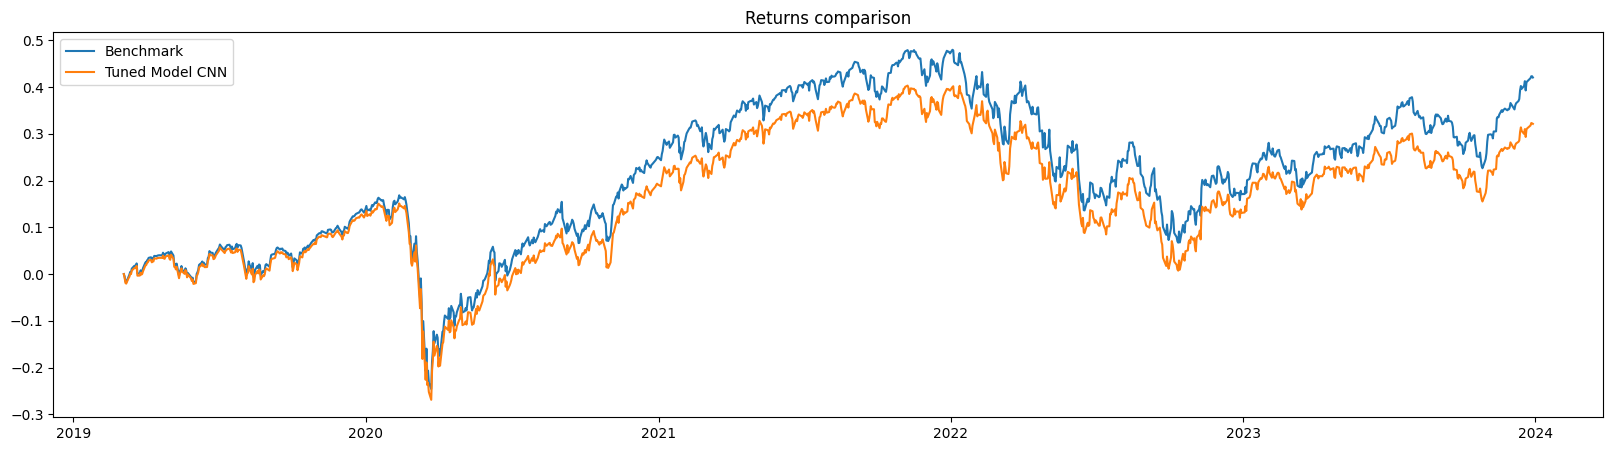

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Tuned Model CNN,0.060235,0.200218,0.300847,0.349327,-0.365047,538.0,0.165007,-0.62803


In [59]:
from helper_functions import run_full_backtesting

models = {'Tuned Model CNN': best_model}
df_results = run_full_backtesting(data_provider, x_test, models)
df_results